In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout

import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math

import json

try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
def samp_to_df(samp_name, total_num):
    dfs = []
    for i in range(total_num+1):
        file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{samp_name}{i}.root'
        samp_file = uproot.open(file_name)
        samp_array = samp_file['tree'].arrays()
        samp_df = pd.DataFrame(samp_array)
        dfs.append(samp_df)
    combine_df = pd.concat(dfs, ignore_index=True)
    return combine_df

# Data loading
def data_to_df(job_run, samp_num):
    file_name = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/{job_run}/dataJob1ifile{samp_num}.root'
    data_file = uproot.open(file_name)
    data_array = data_file['tree'].arrays()
    data_df = pd.DataFrame(data_array)
    return data_df

In [5]:
# Load full data
data_2018_full_dfs = []
for i in range(190):
    data_2018_full_dfs.append(data_to_df('job_1_ntuple20180819v1', i))
data_2018_full_df = pd.concat(data_2018_full_dfs, ignore_index=True)

data_2017_full_dfs = []
for i in range(53):
    data_2017_full_dfs.append(data_to_df('job_1_ntuple20170819v1', i))
data_2017_full_df = pd.concat(data_2017_full_dfs, ignore_index=True)

# data_2016_full_dfs = []
# for i in range(384):
#     data_2016_full_dfs.append(data_to_df('job_1_ntuple20160819v1', i))
# data_2016_full_df = pd.concat(data_2016_full_dfs, ignore_index=True)

In [10]:
import json

# Good luminosity functions

def convert_json_txt_to_dict(file_name):
    with open(file_name) as file:
        data = file.read()
    return json.loads(data)

def good_lumi_list(data_df, good_lumi_dict):
    good_lumis = []
    for index, row in data_df.iterrows():
        run = row[b'run']
        lumi = row[b'lumi']
        good_lumi = 0
        if str(int(run)) in good_lumi_dict:
            lumi_blocks = good_lumi_dict[str(int(run))]
            for lumi_block in lumi_blocks:
                if lumi_block[0] <= lumi and lumi <= lumi_block[1]:
                    good_lumi = 1
                    break
        good_lumis.append(good_lumi)
    return good_lumis


# Get good luminosity dictionaries

Good_Lum_2018 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_314472-325175_13TeV_17SeptEarlyReReco2018ABC_PromptEraD_Collisions18_JSON.txt')
Good_Lum_2017 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_294927-306462_13TeV_EOY2017ReReco_Collisions17_JSON_v1.txt')
Good_Lum_2016 = convert_json_txt_to_dict('/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/data/GoodRunJSON/Cert_271036-284044_13TeV_ReReco_07Aug2017_Collisions16_JSON.txt')

# Good luminosity selection

data_2018_full_df[b'good_lumi'] = good_lumi_list(data_2018_full_df, Good_Lum_2018)
data_2018_good_df = data_2018_full_df[data_2018_full_df[b'good_lumi'] == 1]

data_2017_full_df[b'good_lumi'] = good_lumi_list(data_2017_full_df, Good_Lum_2017)
data_2017_good_df = data_2017_full_df[data_2017_full_df[b'good_lumi'] == 1]

# data_2016_full_df[b'good_lumi'] = good_lumi_list(data_2016_full_df, Good_Lum_2016)
# data_2016_good_df = data_2016_full_df[data_2016_full_df[b'good_lumi'] == 1]

# data_full_df = pd.concat([data_2018_full_df, data_2017_full_df, data_2016_full_df], ignore_index=True)
data_full_df = pd.concat([data_2018_full_df, data_2017_full_df], ignore_index=True) # no 2016

data_full_df_1 = data_full_df[data_full_df[b'diphoton_mass']>135]
data_full_df_2 = data_full_df[data_full_df[b'diphoton_mass']<115]
data_full_df_wind = pd.concat([data_full_df_1, data_full_df_2], ignore_index=True)

In [11]:
GluGluToHH_df_2018 = samp_to_df('job_2_ntuple20180819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
GluGluToHH_df_2017 = samp_to_df('job_2_ntuple20170819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8Job2ifile', 3)
GluGluToHH_df_2016 = samp_to_df('job_2_ntuple20160819v1/GluGluToHHTo2B2G_node_cHHH1_TuneCUETP8M1_PSWeights_13TeV-powheg-pythia8Job2ifile', 0)
GluGluToHH_df = pd.concat([GluGluToHH_df_2018, GluGluToHH_df_2017, GluGluToHH_df_2016], ignore_index=True)

In [12]:
training_vars = [b'leading_photon_eta', b'leading_photon_phi', 
                b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt_corr', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt_corr', b'subleading_bjet_eta', b'subleading_bjet_phi',
                 b'leadingDeepBscore', b'subleadingDeepBscore', b'sumDeepBscore',
                 b'leading_pho_pt_over_dimass', b'subleading_pho_pt_over_dimass',
                 b'diphoton_pt_over_diphoton_mass', b'dibjet_pt_over_dibjet_mass_corr',
                 b'rec_pho_bjet_min_dR', b'all_pho_bjet_min_dR', b'dphi_met_leading_bjet', b'dphi_met_subleading_bjet',
                 b'MET_pt', b'MET_phi', b'MET_sumEt',
                 b'nbjet', b'nphoton', b'njet'
                ]

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

In [13]:
path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'

sig_frame_all = GluGluToHH_df
bkg_frame_all = data_full_df_wind.drop(axis=1, columns =[b'good_lumi'])

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars]


sig_df = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]
bkg_df = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][training_vars + w_var + aug_vars]

sig_weight = sig_frame_all[sig_frame_all[b'leading_photon_pt'] > 0][sig_frame_all[b'leading_bjet_pt'] > 0][w_var]
bkg_weight = bkg_frame_all[bkg_frame_all[b'leading_photon_pt'] > 0][bkg_frame_all[b'leading_bjet_pt'] > 0][w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

In [14]:
bkg_frame_all.head()

,b'run',b'lumi',b'event',b'trig_decision',b'pv_pass',b'njet',b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',...,b'MET_pt',b'MET_phi',b'MET_sumEt',b'dphi_met_leading_bjet',b'dphi_met_subleading_bjet',b'fatJetPt',b'fatJetEta',b'fatJetPhi',b'fatJetMassSD_UnCorrected',b'fatJetbtagDDBvL'
0,315801,89,91094387,1,1,6,92.063103,-1.227051,2.780273,42.311184,...,57.510704,-1.709961,1634.0,1.472656,1.170898,-999.0,-999.0,-999.0,-999.0,-999.0
1,315801,169,170221697,1,1,8,85.579910,-1.138672,-0.582275,53.044937,...,81.721809,-2.278320,2050.0,3.026611,-2.205793,-999.0,-999.0,-999.0,-999.0,-999.0
2,316569,1902,2655106482,1,1,5,107.546097,0.561157,3.032227,74.147636,...,33.472588,0.786255,867.5,-1.063965,1.362183,-999.0,-999.0,-999.0,-999.0,-999.0
3,316590,59,66121898,1,1,11,83.010948,0.726074,-1.572998,53.931732,...,49.577843,0.784668,2386.0,2.727033,-0.172485,-999.0,-999.0,-999.0,-999.0,-999.0
4,316590,59,65700481,1,1,10,97.503487,0.291443,2.255859,63.559029,...,50.781422,-2.312988,1737.0,1.881592,-2.332746,-999.0,-999.0,-999.0,-999.0,-999.0


In [15]:
sig_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'MET_pt',b'MET_phi',b'MET_sumEt',b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,0.918335,0.491089,0.319824,1.547607,151.140625,2.209473,-2.042480,23.716171,0.004900,-0.789917,...,13.275213,-2.522461,1867.0,3,2,12,0.000028,188.683197,123.416451,112008
1,-0.114059,2.528809,-0.079712,0.564209,89.827637,-1.288086,-0.381775,63.123047,-1.138916,-2.197266,...,31.468651,-0.515259,1177.0,3,2,6,-0.000028,111.977684,124.439453,112017
2,-0.835327,1.176514,-0.765747,2.546875,117.749023,-1.357910,-1.699951,75.133667,-0.727295,-0.625854,...,14.875567,-0.652832,1778.0,2,2,5,0.000028,111.282120,124.160385,112010
3,-0.390930,-0.474426,-0.526611,1.511963,100.517090,0.323792,2.379883,32.967285,2.041504,-3.094238,...,31.621542,1.783203,2834.0,2,2,10,0.000028,106.316811,124.160637,112001
4,2.106934,-1.360596,1.376465,0.152924,164.816162,1.395996,2.549316,27.756042,1.725098,0.694458,...,45.979630,0.716797,2928.0,2,2,13,0.000028,125.170486,120.000145,112006


In [16]:
bkg_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'MET_pt',b'MET_phi',b'MET_sumEt',b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event'
0,-1.227051,2.780273,0.087067,2.445312,148.395264,-0.328064,-0.237305,48.791504,-0.852661,-0.539062,...,57.510704,-1.709961,1634.0,3,2,6,1.0,57.204453,156.186508,91094387
1,-1.138672,-0.582275,-2.199219,3.125977,82.572510,-1.513428,0.748291,42.369049,-2.322754,1.799072,...,81.721809,-2.278320,2050.0,2,2,8,1.0,67.633553,149.472626,170221697
2,0.561157,3.032227,0.751709,-0.780151,85.864746,-0.025852,-0.277710,49.530273,1.325928,2.148438,...,33.472588,0.786255,867.5,2,2,5,1.0,151.237228,169.505341,2655106482
3,0.726074,-1.572998,-0.297974,0.726318,79.992920,-1.269287,-2.771484,34.598282,0.821533,0.612183,...,49.577843,0.784668,2386.0,3,2,11,1.0,169.759399,141.544144,66121898
4,0.291443,2.255859,0.238739,-1.518799,99.466553,-0.728760,-0.431396,64.134888,0.363220,1.637451,...,50.781422,-2.312988,1737.0,2,2,10,1.0,148.346741,149.680664,65700481


In [17]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background
signal_all = sig_df.values
background_all = bkg_df.values

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
signal_all_=signal_all[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_all_ = background_all[randix]
#background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))
data_all = np.concatenate((signal_all_,background_all_))

sig_weight_np = sig_weight.values
bkg_weight_np = bkg_weight.values
sig_weight_np_sfl = sig_weight_np[randix2]
bkg_weight_np_sfl = bkg_weight_np[randix]
weights = np.concatenate((sig_weight_np_sfl, bkg_weight_np_sfl))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [18]:
# full df prep
sig_frame_full = sig_frame_all.values
sig_frame_full = sig_frame_full[randix2]
bgd_frame_full = bkg_frame_all.values
bgd_frame_full=bgd_frame_full[randix]
data_full = np.concatenate((sig_frame_full, bgd_frame_full))

In [19]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]
    train_weight, test_weight = weights[train_index], weights[test_index]
    x_all_test = data_all[test_index]
    #x_full_test = data_full[test_index] # full df test portion

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

TRAIN: [     1      2      3 ... 371250 371251 371252] TEST: [     0     10     16 ... 371245 371246 371247]
TRAIN: [     0      1      2 ... 371250 371251 371252] TEST: [     7      8      9 ... 371231 371239 371240]
TRAIN: [     0      1      2 ... 371247 371249 371251] TEST: [     5     18     30 ... 371248 371250 371252]
TRAIN: [     0      2      3 ... 371250 371251 371252] TEST: [     1      4     11 ... 371241 371243 371249]
TRAIN: [     0      1      4 ... 371249 371250 371252] TEST: [     2      3      6 ... 371226 371230 371251]
(297003, 27)
(297003,)
(74250, 27)
(74250,)


In [20]:
sig_total_weight = np.sum(sig_frame_all.loc[:, b'genweight'].values)
bgd_total_weight = np.sum(bkg_frame_all.loc[:, b'genweight'].values)

sig_test_weights = test_weight[y_test == 1]
bgd_test_weights = test_weight[y_test == 0]
sig_test_total_weight = np.sum(sig_test_weights)
bgd_test_total_weight = np.sum(bgd_test_weights)

scale_sig = sig_total_weight / sig_test_total_weight
scale_bgd = bgd_total_weight / bgd_test_total_weight

## Model

In [21]:
def DNN_model(n_hidden = 1, first_neuron = 100, n_neurons = 64, dropout_rate = 0.4, activation_func = 'sigmoid', lr= 0.0001):
    model = Sequential()
    model.add(Dense(first_neuron, input_dim=len(training_vars), activation='relu'))
    model.add(Dropout(dropout_rate))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation = activation_func))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = 'sigmoid'))
    opt = Adam(learning_rate = lr)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [24]:
model = DNN_model(5, 88, 115, 0.01, 'sigmoid', 0.000173)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='Models/full/combine_mass_model_1.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
1585/1585 [==============================] - 4s 3ms/step - loss: 0.3065 - accuracy: 0.8627 - val_loss: 0.1984 - val_accuracy: 0.9202
Epoch 2/50
1585/1585 [==============================] - 4s 2ms/step - loss: 0.2238 - accuracy: 0.9108 - val_loss: 0.1779 - val_accuracy: 0.9289
Epoch 3/50
1585/1585 [==============================] - 4s 2ms/step - loss: 0.2179 - accuracy: 0.9131 - val_loss: 0.1826 - val_accuracy: 0.9276
Epoch 4/50
1585/1585 [==============================] - 4s 2ms/step - loss: 0.2139 - accuracy: 0.9147 - val_loss: 0.2413 - val_accuracy: 0.9005
Epoch 5/50
1585/1585 [==============================] - 13s 8ms/step - loss: 0.2107 - accuracy: 0.9165 - val_loss: 0.1823 - val_accuracy: 0.9284
Epoch 6/50
1585/1585 [==============================] - 4s 2ms/step - loss: 0.2083 - accuracy: 0.9173 - val_loss: 0.2022 - val_accuracy: 0.9182
Epoch 7/50
1585/1585 [==============================] - 4s 3ms/step - loss: 0.2065 - accuracy: 0.9179 - val_loss: 0.1667 - val_accuracy

2021-09-30 16:00:27.667923: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


## Results

In [25]:
# Accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp)
print("Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Training Accuracy: 92.47%
Accuracy: 92.53%


In [28]:
# Weighted accuracy

y_train_tmp = model.predict(x_train)
predictions_train_tmp = [round(value[0]) for value in y_train_tmp]
train_accuracy = accuracy_score(y_train, predictions_train_tmp, sample_weight = train_weight.ravel())
print("Weighted Training Accuracy: %.2f%%" % (train_accuracy * 100.0))

y_pred_tmp = model.predict(x_test)
predictions_tmp = [round(value[0]) for value in y_pred_tmp]
accuracy = accuracy_score(y_test, predictions_tmp, sample_weight = test_weight.ravel())
print("Weighted Accuracy: %.2f%%" % (accuracy * 100.0))

Weighted Training Accuracy: 92.59%
Weighted Accuracy: 92.62%


In [29]:
y_pred2 = model.predict(x_test)
y_pred = y_pred2.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred, sample_weight = test_weight.ravel())
auc_keras = auc(fpr_keras, tpr_keras)

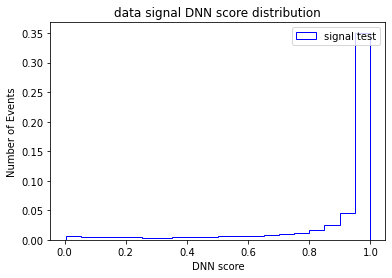

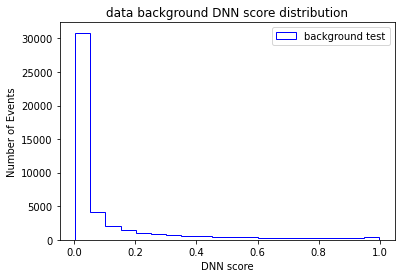

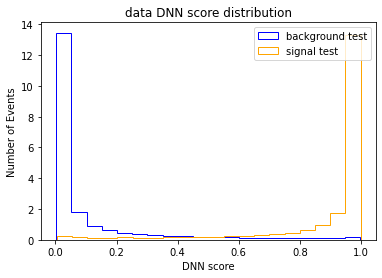

In [32]:
# Plot DNN score distribution

bgd = y_pred[y_test == 0]
sgl = y_pred[y_test == 1]
sgl_weight = test_weight[y_test == 1].flatten()
bgd_weight = test_weight[y_test == 0].flatten()

plt.hist(sgl, color='blue', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.55, ymin=0, ymax = 0.10, color = 'orange')
plt.legend(loc = 'best')
plt.title('data signal DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_sig_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test')
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
#plt.vlines(0.5, ymin=0, ymax = 10, color = 'orange')
plt.legend(loc = 'best')
plt.title('data background DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_bkg_score.png', format='png')
plt.show()

plt.hist(bgd, color='blue', weights= bgd_weight, histtype='step', bins = 20, label= 'background test', density=True)
plt.hist(sgl, color='orange', weights= sgl_weight, histtype='step', bins = 20, label= 'signal test', density=True)
plt.xlabel('DNN score')
plt.ylabel('Number of Events')
plt.legend(loc = 'best')
plt.title('data DNN score distribution')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_score.png', format='png')
plt.show()

In [33]:
bgd_x_all = x_all_test[y_test == 0]
bgd_y = y_pred[y_test == 0]
bgd_test = y_test[y_test == 0]

sig_x_all = x_all_test[y_test == 1]
sig_y = y_pred[y_test == 1]
sig_test = y_test[y_test == 1]

result_sig_df = pd.DataFrame(sig_x_all, columns = list(sig_df.columns))
result_sig_df[b'DNN_score'] = sig_y
result_bgd_df = pd.DataFrame(bgd_x_all, columns = list(bkg_df.columns))
result_bgd_df[b'DNN_score'] = bgd_y

In [34]:
# make copy of dataframe
result_sig_df_alt = pd.DataFrame()
result_bgd_df_alt = pd.DataFrame()
for column in list(result_sig_df.columns):
    result_sig_df_alt[column] = result_sig_df.loc[:, column].values
    result_bgd_df_alt[column] = result_bgd_df.loc[:, column].values

In [35]:
result_sig_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'MET_phi',b'MET_sumEt',b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN_score'
0,-0.628540,3.135254,-1.096680,-0.052147,55.425751,0.198700,-0.106979,26.478958,1.229736,-1.706543,...,1.022949,573.5,3.0,2.0,6.0,0.000016,67.779968,127.142517,195026.0,0.870380
1,-1.242432,0.118973,0.179993,0.316406,153.199951,-0.141205,-2.244141,55.122253,-0.336243,-0.820801,...,2.299316,2454.0,5.0,2.0,9.0,0.000028,116.821136,124.049416,172732.0,0.942517
2,1.892334,-0.765015,1.074219,0.607056,103.736267,1.453369,2.165039,44.700836,1.053467,-2.577637,...,-2.763672,2025.0,2.0,2.0,8.0,-0.000019,92.812744,123.939590,60000.0,0.940806
3,0.383301,-2.711426,-0.218597,2.827148,273.822021,1.750000,0.089722,61.787109,1.892090,0.793579,...,1.024658,1249.0,3.0,2.0,7.0,0.000028,99.663834,124.820999,67840.0,0.998146
4,-1.104736,-1.697021,-2.345703,-1.041748,175.312500,-0.847290,1.395752,64.321655,-0.835449,2.537109,...,2.361328,1901.0,2.0,2.0,11.0,0.000016,100.844536,127.026909,146010.0,0.997636


In [36]:
result_bgd_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'MET_phi',b'MET_sumEt',b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN_score'
0,-1.729492,1.930176,-1.670410,-1.578369,77.168518,-1.172852,-1.035156,41.362457,-0.478210,2.091797,...,0.418518,1481.0,2.0,2.0,7.0,1.0,113.475761,101.664932,8.965252e+08,0.011974
1,1.251709,3.058594,-0.543457,1.947021,97.007935,0.158020,-2.728027,60.404999,0.654419,-1.107910,...,-0.341492,1696.0,6.0,3.0,13.0,1.0,111.572296,100.352478,1.724514e+09,0.029824
2,0.346252,2.842773,0.332520,-1.340332,87.835693,0.853760,2.989258,28.111633,-0.762085,-0.303101,...,1.632080,2230.0,2.0,2.0,8.0,1.0,109.955292,104.088608,5.927316e+07,0.057695
3,0.373596,-0.016796,0.023422,3.012207,33.867264,-1.692383,1.456787,29.463348,-0.914795,-0.669067,...,2.065430,3292.0,3.0,2.0,16.0,1.0,57.211193,164.289093,1.060366e+09,0.116039
4,-0.382935,1.235107,-1.794434,0.001703,71.560547,-1.843018,-2.555664,38.796295,-0.060417,-2.729980,...,-0.523071,1341.0,2.0,2.0,6.0,1.0,101.050301,107.166054,8.497387e+08,0.031500


In [37]:
from ROOT import RDF
from ROOT import Internal

result_sig_dict = {key.decode("utf-8"): result_sig_df_alt[key].values for key in list(result_sig_df_alt.columns)}
result_bgd_dict = {key.decode("utf-8"): result_bgd_df_alt[key].values for key in list(result_bgd_df_alt.columns)}
sig_rdf = rt.RDF.MakeNumpyDataFrame(result_sig_dict)
bgd_rdf = rt.RDF.MakeNumpyDataFrame(result_bgd_dict)
sig_rdf.Snapshot('tree', f'DNN_Trees/data/data_sig_DNN_file.root')
bgd_rdf.Snapshot('tree', f'DNN_Trees/data/data_bgd_DNN_file.root')

<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x4dc0eb60>

In [38]:
file_name = f'DNN_Trees/data/data_sig_DNN_file.root'
data_file = uproot.open(file_name)
data_array = data_file['tree'].arrays()
data_df = pd.DataFrame(data_array)
data_df.head()

,b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt_corr',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt_corr',b'subleading_bjet_eta',b'subleading_bjet_phi',...,b'MET_phi',b'MET_sumEt',b'nbjet',b'nphoton',b'njet',b'genweight',b'dibjet_mass',b'diphoton_mass',b'event',b'DNN_score'
0,-0.628540,3.135254,-1.096680,-0.052147,55.425751,0.198700,-0.106979,26.478958,1.229736,-1.706543,...,1.022949,573.5,3.0,2.0,6.0,0.000016,67.779968,127.142517,195026.0,0.870380
1,-1.242432,0.118973,0.179993,0.316406,153.199951,-0.141205,-2.244141,55.122253,-0.336243,-0.820801,...,2.299316,2454.0,5.0,2.0,9.0,0.000028,116.821136,124.049416,172732.0,0.942517
2,1.892334,-0.765015,1.074219,0.607056,103.736267,1.453369,2.165039,44.700836,1.053467,-2.577637,...,-2.763672,2025.0,2.0,2.0,8.0,-0.000019,92.812744,123.939590,60000.0,0.940806
3,0.383301,-2.711426,-0.218597,2.827148,273.822021,1.750000,0.089722,61.787109,1.892090,0.793579,...,1.024658,1249.0,3.0,2.0,7.0,0.000028,99.663834,124.820999,67840.0,0.998146
4,-1.104736,-1.697021,-2.345703,-1.041748,175.312500,-0.847290,1.395752,64.321655,-0.835449,2.537109,...,2.361328,1901.0,2.0,2.0,11.0,0.000016,100.844536,127.026909,146010.0,0.997636


In [39]:
# Bkg reduction
# Bkg reduction
def significance_file(k):
    file.write(f'cutoff: {k}\n')
    bgd = y_pred[y_test == 0]
    file.write(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    file.write(f'# false signal: {sum(bgd_bin)}\n')

    sgl = y_pred[y_test == 1]
    file.write(f'# signal: {len(sgl)}\n')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    file.write(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    file.write(f'original background: {np.sum(bkg_weight_np_sfl)}\n')
    file.write(f'original test background: {np.sum(bgd_weight)}\n')
    file.write(f'original signal: {np.sum(sig_weight_np_sfl)}\n')
    file.write(f'original test signal: {np.sum(sgl_weight)}\n')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    file.write(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    file.write(f'remaining signal: {re_sig}\n')
    file.write(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    file.write(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    file.write(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    file.write('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

def significance_print(k):
    print(f'cutoff: {k}')
    bgd = y_pred[y_test == 0]
    print(f'# background: {len(bgd)}\n')
    bgd_bin = []
    for event in bgd:
        if event >= k:
            bgd_bin.append(1)
        else:
            bgd_bin.append(0)
    print(f'# false signal: {sum(bgd_bin)}\n')

    bgd = y_pred[y_test == 0]
    print(f'# signal: {len(sgl)}')
    sgl_bin = []
    for event in sgl:
        if event >= k:
            sgl_bin.append(1)
        else:
            sgl_bin.append(0)
    print(f'# true signal: {sum(sgl_bin)}\n')
    bgd_bin_np = np.array(bgd_bin)
    sgl_bin_np = np.array(sgl_bin)
    sgl_weight = test_weight[y_test == 1].flatten()
    bgd_weight = test_weight[y_test == 0].flatten()
    print(f'original background: {np.sum(bkg_weight_np_sfl)}')
    print(f'original test background: {np.sum(bgd_weight)}')
    print(f'original signal: {np.sum(sig_weight_np_sfl)}')
    print(f'original test signal: {np.sum(sgl_weight)}')

    re_bkg = np.sum(bgd_bin_np * bgd_weight)
    print(f'remaining background: {re_bkg}\n')
    re_sig = np.sum(sgl_bin_np * sgl_weight)
    print(f'remaining signal: {re_sig}\n')
    print(f'original S/sqrt(S+B): {np.sum(sig_weight_np_sfl) / np.sqrt(np.sum(sig_weight_np_sfl) + np.sum(bkg_weight_np_sfl))}\n')
    print(f'original test S/sqrt(S+B): {np.sum(sgl_weight) / np.sqrt(np.sum(sgl_weight) + np.sum(bgd_weight))}\n')
    print(f'S/sqrt(S+B): {re_sig / np.sqrt(re_sig + re_bkg)}\n')
    print('\n')
    return re_sig / np.sqrt(re_sig + re_bkg)

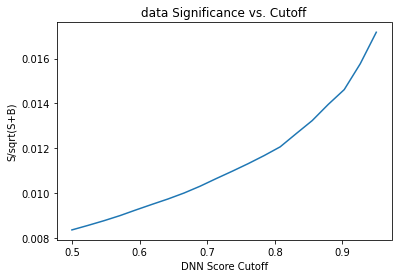

In [40]:
test_sc = np.linspace(0.5, 0.95, 20)
sc_vals = []
file = open('DNN_Score_Nums/data/data_mass_DNN_score.txt', "w")
for value in test_sc:
    sc_vals.append(significance_file(value))

file.close()
    
plt.plot(test_sc, sc_vals, label = 'data')
plt.xlabel('DNN Score Cutoff')
plt.ylabel('S/sqrt(S+B)')
plt.title('data Significance vs. Cutoff')
plt.savefig(fname = f'DNN_Score_Plts/data/data_mass_significance.png', format='png')
plt.show()

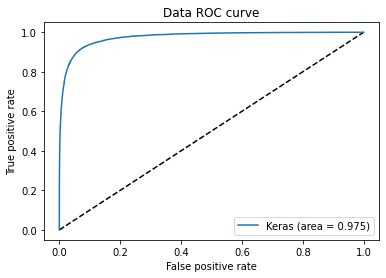

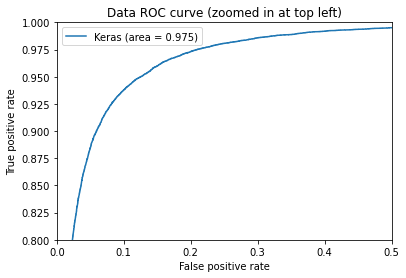

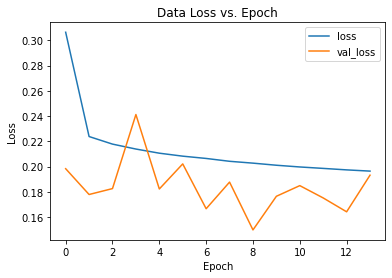

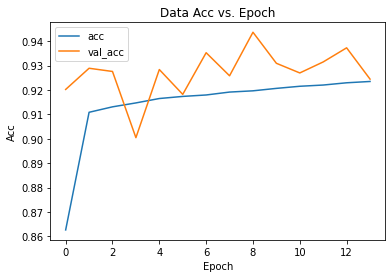

In [41]:
# Plots

# ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Data ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/data/data_mass_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner ROC curve
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('Data ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'ROC_Plts/data/data_mass_ROC_curve_zoom')
plt.show()


# plot loss vs epoch
plt.figure(3)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Data Loss vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/data/data_mass_loss_epoch.png', format='png')
plt.show()

# plot accuracy vs epoch
plt.figure(4)
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.legend(loc="best")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Data Acc vs. Epoch')
plt.savefig(fname = f'Epoch_Plts/data/data_mass_acc_epoch.png', format='png')
plt.show()

In [42]:
file = open('Efficiency/data/data_mass_DNN_efficiency.txt', "w")
file.write('1% acceptance\n')
for x in tpr_keras[fpr_keras>=0.009997]:
    if x in tpr_keras[fpr_keras<=0.01]:
        file.write(f'{x}\n')

file.write('\n')

file.write('0.1% acceptance\n')
for y in tpr_keras[fpr_keras>=0.0009997]:
    if y in tpr_keras[fpr_keras<=0.001]:
        file.write(f'{y}\n')
file.close()

In [43]:
def check_mass_gg(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure()
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=fontsize)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('data '+samples[label])
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_mass_gg_mass_sculpt_{samples[label]}')
    
def check_mass_jj(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(110, 140, 20)
    plt.figure()
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=12)
    plt.xlabel(r'$m_{jj}$',fontsize=fontsize)
    plt.title('data '+samples[label])
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_mass_jj_mass_sculpt_{samples[label]}')

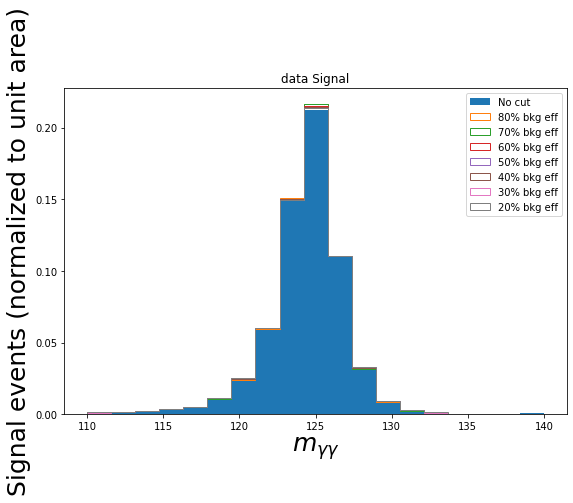

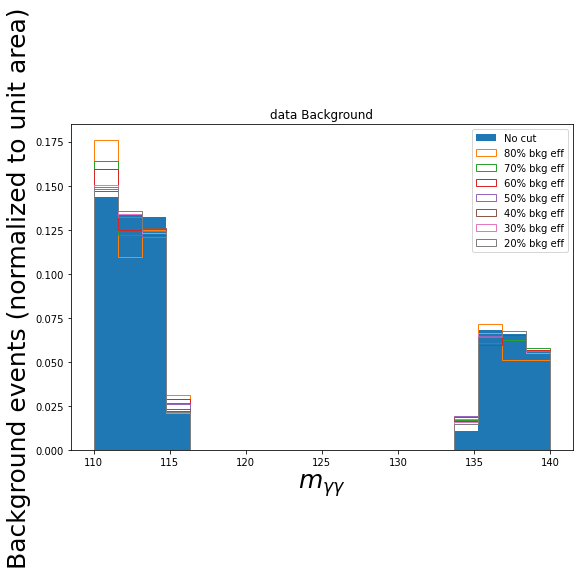

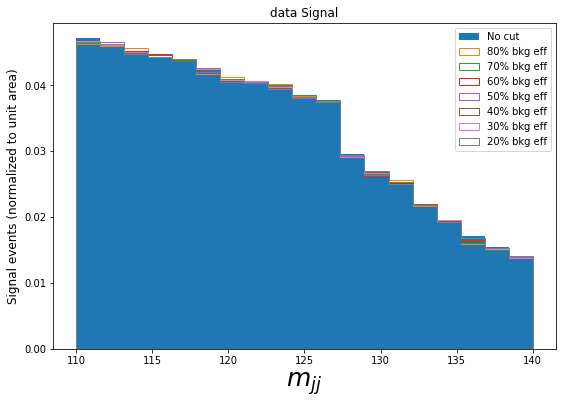

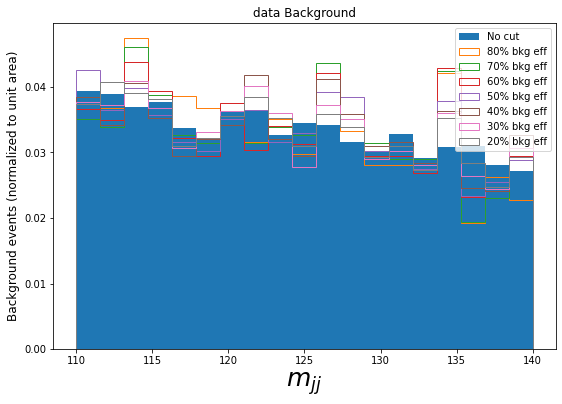

In [46]:
label_test = np.array([y_test]).T
test_all = np.concatenate((x_all_test,y_pred2, label_test), 1)
#signal
check_mass_gg(1, test_all, 29, 27, 31, 32)
#bkg
check_mass_gg(0, test_all, 29, 27, 31, 32)

#signal
check_mass_jj(1, test_all, 28, 27, 31, 32)
#bkg
check_mass_jj(0, test_all, 28, 27, 31, 32)

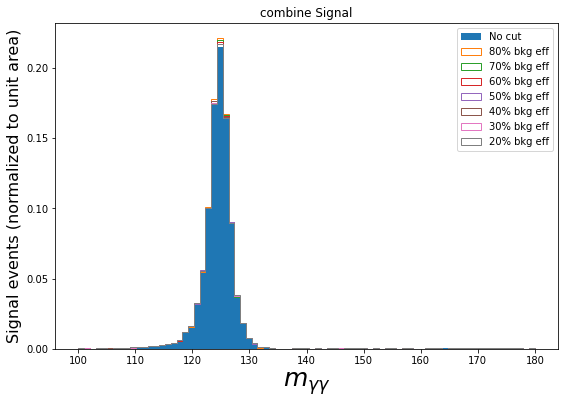

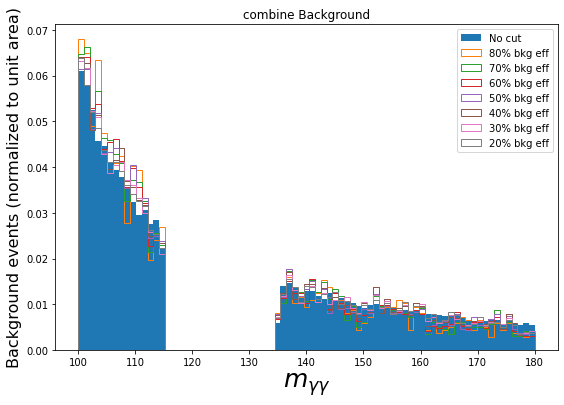

In [47]:
def check_mass_gg_full(label, test_all, var_index, weight_index, dnn_index, label_index):
    samples = ['Background', 'Signal']
    fontsize=25
    TPR_thresholds = [0.8,0.7,0.6, 0.5, 0.4, 0.3,0.2]
    bins = np.linspace(100, 180, 80)
    plt.figure(figsize=(9,6))
    plt.hist(test_all[:,var_index][test_all[:,label_index]==label], bins=bins, weights=test_all[:,weight_index][test_all[:,label_index]==label], density=True, label='No cut')
    for TPR_threshold in TPR_thresholds:
        #print(TPR_threshold)
    
        tmp = test_all[np.where((test_all[:,label_index]==label)*(test_all[:,dnn_index]>TPR_threshold))]
        plt.hist(tmp[:,var_index],
             bins=bins, histtype='step', 
             weights=tmp[:,weight_index], 
             label= "{:.0f}% bkg eff".format(100*TPR_threshold),
             density=True)
    
    plt.legend(loc='best')
    plt.ylabel(samples[label] + ' events (normalized to unit area)',fontsize=16)
    plt.xlabel(r'$m_{\gamma\gamma}$',fontsize=fontsize)
    plt.title('combine '+samples[label])
    plt.savefig(fname = f'Mass_Sculpt_Plts/data/data_fullrange_mass_gg_mass_sculpt_{samples[label]}_1')

#signal
check_mass_gg_full(1, test_all, 29, 27, 31, 32)
#bkg
check_mass_gg_full(0, test_all, 29, 27, 31, 32)

In [82]:
# addressing mass sculpting 
def mass_DNN_score(df, FPR_cut, mass_min, mass_max):
    df_range_1 = df[df[b'diphoton_mass'] < mass_max]
    df_range = df_range_1[df_range_1[b'diphoton_mass'] >= mass_min]
    df_values = df_range.sort_values(by = [b'DNN_score'])
    weight_array = df_values.loc[:, b'genweight'].values
    DNN_score_array = df_values.loc[:, b'DNN_score'].values
    total_weight = np.sum(weight_array)
    tn_percent = 1 - FPR_cut
    tn_weight = total_weight * tn_percent
    weight_sum = 0
    for i in range(weight_array.shape[0]):
        weight_sum += weight_array[i]
        if weight_sum >= tn_weight:
            return DNN_score_array[i]
        
def DNN_cuts(bins, df, FPR):
    DNN_cuts = []
    for i in range(bins.shape[0] - 1):
        DNN_cuts.append(mass_DNN_score(df, FPR / 100, bins[i], bins[i+1]))
    return DNN_cuts

def DNN_cut_pass(bins, df, DNN_cuts):
    df_cuts = []
    df_sort = df.sort_values(by = [b'diphoton_mass'])
    for i in range(bins.shape[0] - 1):
        mass_min = bins[i]
        mass_max = bins[i+1]
        df_mass_1 = df_sort[df_sort[b'diphoton_mass'] < mass_max]
        df_mass = df_mass_1[df_mass_1[b'diphoton_mass'] >= mass_min]
        DNN_scores = df_mass.loc[:, b'DNN_score'].values
        for j in range(DNN_scores.shape[0]):
            if DNN_scores[j] >= DNN_cuts[i]:
                df_cuts.append(1)
            else:
                df_cuts.append(0)
    return df_cuts

def plot_mass_sculpt_w_cut(df_sort, mass_bins, samp_name, FPR):
    ori_mass = df_sort.loc[:, b'diphoton_mass'].values
    ori_weight = df_sort.loc[:, b'genweight'].values
    cut_df = df_sort[df_sort[b'mass_sculpt_cut'] == 1]
    cut_mass = cut_df.loc[:, b'diphoton_mass'].values
    cut_weight = cut_df.loc[:, b'genweight'].values
    plt.figure()
    plt.hist(ori_mass, bins = mass_bins, weights = ori_weight, label = 'uncut', density = True)
    plt.hist(cut_mass, bins = mass_bins, weights = cut_weight, histtype='step', label = 'cut', density = True )
    plt.legend(loc = 'best')
    plt.xlabel('Diphoton Mass')
    plt.ylabel('Number of Events')
    plt.title(f'{samp_name} Distribution')
    plt.savefig(fname = f'Mass_Sculpt_Plts/full/combine_mgg_{samp_name}_cut_{FPR}')
    plt.show()

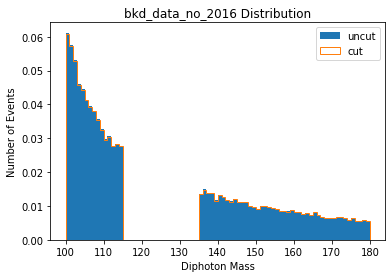

In [83]:
bins_1 = np.linspace(100, 115, 16)
bins_2 = np.linspace(135, 180, 46)
bins = np.hstack((bins_1, bins_2))
FPR = 8
DNN_sc_cuts_1 = DNN_cuts(bins_1, result_bgd_df, FPR)
DNN_sc_cuts_2 = DNN_cuts(bins_2, result_bgd_df, FPR)
result_bgd_df_sort = result_bgd_df.sort_values(by = [b'diphoton_mass'])
#result_sig_df_sort = result_sig_df.sort_values(by = [b'diphoton_mass'])
bkd_cut_1 = DNN_cut_pass(bins_1, result_bgd_df_sort, DNN_sc_cuts_1)
bkd_cut_2 = DNN_cut_pass(bins_2, result_bgd_df_sort, DNN_sc_cuts_2)
result_bgd_df_sort[b'mass_sculpt_cut'] = bkd_cut_1 + bkd_cut_2
plot_mass_sculpt_w_cut(result_bgd_df_sort, bins, 'bkd_data_no_2016', FPR)
#sig_cut_1 = DNN_cut_pass(bins_1, result_sig_df_sort, DNN_sc_cuts_1)
#sig_cut_2 = DNN_cut_pass(bins_2, result_sig_df_sort, DNN_sc_cuts_2)
#result_sig_df_sort[b'mass_sculpt_cut'] = sig_cut_1 + sig_cut_2
#plot_mass_sculpt_w_cut(result_sig_df_sort, bins, 'sig_data_no_2016', FPR)

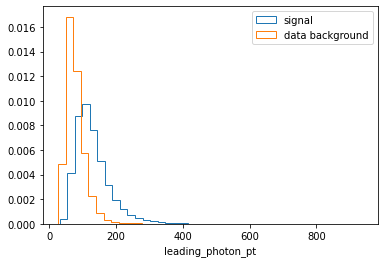

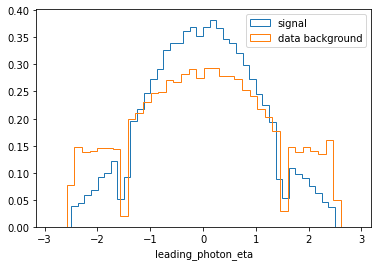

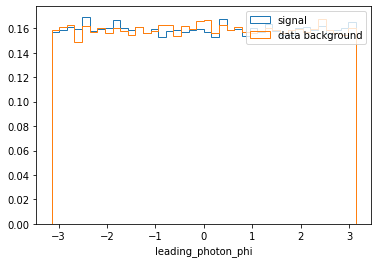

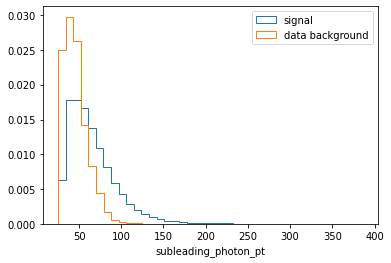

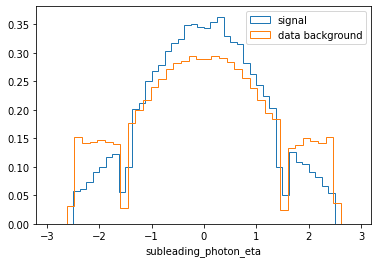

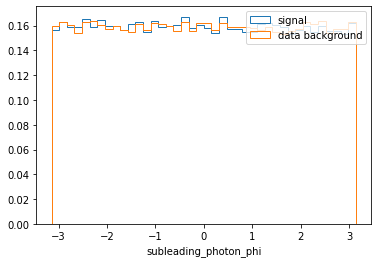

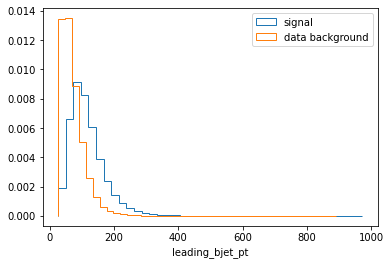

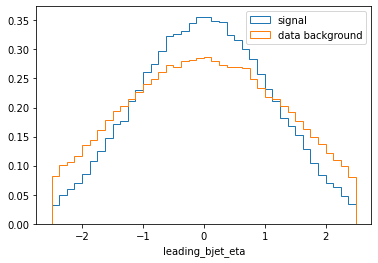

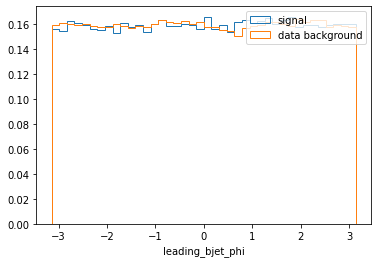

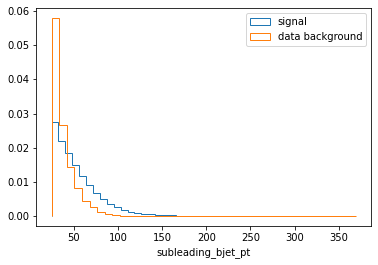

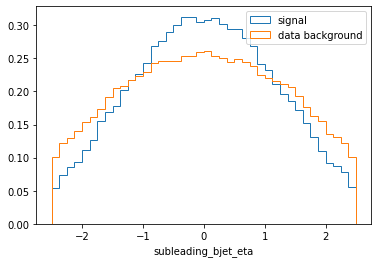

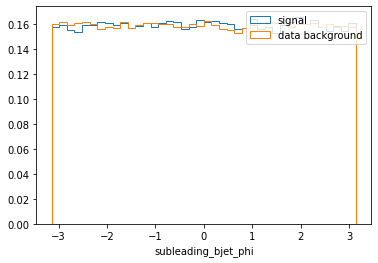

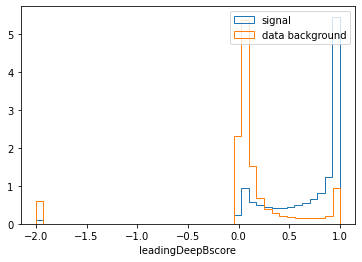

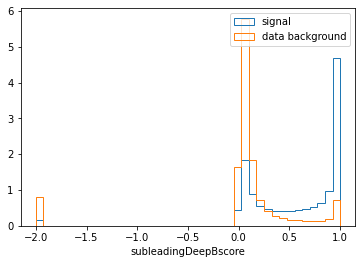

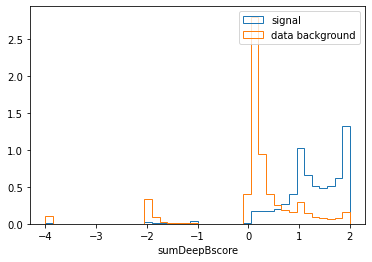

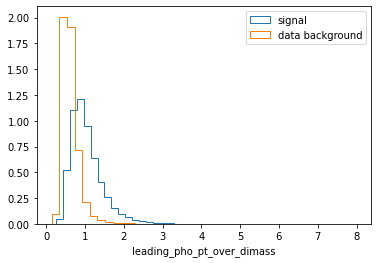

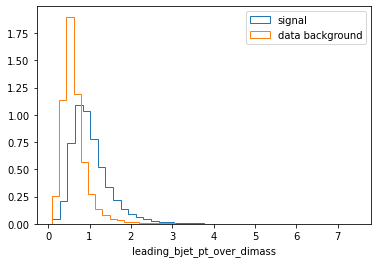

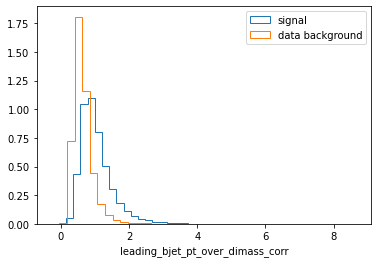

In [64]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= 'data background')
    plt.xlabel(hlf.decode("utf-8"))
    plt.savefig(fname = f'BackgroundVsSignal_Plts/data/data_{hlf}')
    plt.legend(loc='best')

# 